In [139]:
import warnings

warnings.filterwarnings('ignore')

import cv2
import os
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D, Dense, Conv2DTranspose
from keras.layers import Dropout
from keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import tensorflow 
tensorflow.config.run_functions_eagerly(True)

In [238]:
# Model Variables
img_width = 128
img_height = 128
channels = 3
img_shape = (img_width, img_height, channels)
latent_dim = 100 # Noise which will feed into model. WHY ONLY 100
adam = Adam(learning_rate=0.0002)

In [239]:
def build_generator():
    model = Sequential()
    
    # Layer 1
    model.add(Dense(256 * 16* 16, input_dim=latent_dim)) # 128/2/2/2 because 3 conv2d layers?
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((16,16,256)))
    
    # Layer 2
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    # Layer 3
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    # Layer 4
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    #Layer 5
    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
  
    model.summary()

    return model

generator = build_generator()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 65536)             6619136   
                                                                 
 leaky_re_lu_108 (LeakyReLU)  (None, 65536)            0         
                                                                 
 reshape_19 (Reshape)        (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose_54 (Conv2D  (None, 32, 32, 128)      524416    
 Transpose)                                                      
                                                                 
 leaky_re_lu_109 (LeakyReLU)  (None, 32, 32, 128)      0         
                                                                 
 conv2d_transpose_55 (Conv2D  (None, 64, 64, 128)      262272    
 Transpose)                                          

In [240]:
def build_discriminator():
    model = Sequential()
    
    # Layer 1
    model.add(Conv2D(64, (3,3), padding='same', input_shape=img_shape))
    model.add(LeakyReLU(alpha=0.2))
    
    # Layer 2
    model.add(Conv2D(128, (3,3), padding='same', ))
    model.add(LeakyReLU(alpha=0.2))
    
    # Layer 3
    model.add(Conv2D(128, (3,3), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    # Layer 4
    model.add(Conv2D(256, (3,3), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    # Layer 5
    model.add(Flatten())
    model.add(Dropout(0.4)) # Drop 40% of neurons
    model.add(Dense(1, activation='sigmoid')) 

    model.summary()
    return model

discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_55 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 leaky_re_lu_112 (LeakyReLU)  (None, 128, 128, 64)     0         
                                                                 
 conv2d_56 (Conv2D)          (None, 128, 128, 128)     73856     
                                                                 
 leaky_re_lu_113 (LeakyReLU)  (None, 128, 128, 128)    0         
                                                                 
 conv2d_57 (Conv2D)          (None, 128, 128, 128)     147584    
                                                                 
 leaky_re_lu_114 (LeakyReLU)  (None, 128, 128, 128)    0         
                                                                 
 conv2d_58 (Conv2D)          (None, 128, 128, 256)   

In [241]:
# Combine into one model
GAN = Sequential()
discriminator.trainable = False #discriminator weights don't train with GAN
GAN.add(generator)
GAN.add(discriminator)

GAN.compile(loss='binary_crossentropy', optimizer=adam)

In [119]:
import boto3

sess = boto3.Session(region_name='us-east-2')
client = sess.client('s3')

In [120]:
#response = 
client.head_object(Bucket='tellisa-collage-gan', Key='collage_imgs.csv')

{'ResponseMetadata': {'RequestId': '5YJ4YZ6D84MQDGJC',
  'HostId': 'AUhtP4BGnCumx60ounA/BuCRdrnE8yeR7doxfjEU878dheJstz1uwjjk5W5z8j5wL7Cto/tEkB4=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'AUhtP4BGnCumx60ounA/BuCRdrnE8yeR7doxfjEU878dheJstz1uwjjk5W5z8j5wL7Cto/tEkB4=',
   'x-amz-request-id': '5YJ4YZ6D84MQDGJC',
   'date': 'Sat, 12 Nov 2022 23:32:04 GMT',
   'last-modified': 'Sat, 12 Nov 2022 22:15:36 GMT',
   'etag': '"01cd5c9413747390bdad24948ade0a4e-405"',
   'accept-ranges': 'bytes',
   'content-type': 'binary/octet-stream',
   'server': 'AmazonS3',
   'content-length': '3389422907'},
  'RetryAttempts': 0},
 'AcceptRanges': 'bytes',
 'LastModified': datetime.datetime(2022, 11, 12, 22, 15, 36, tzinfo=tzutc()),
 'ContentLength': 3389422907,
 'ETag': '"01cd5c9413747390bdad24948ade0a4e-405"',
 'ContentType': 'binary/octet-stream',
 'Metadata': {}}

In [121]:
obj = client.get_object(Bucket='tellisa-collage-gan', Key='collage_imgs.csv')

In [122]:
#df = pd.read_csv(obj["Body"],chunksize = 5)

In [123]:
data_iter = pd.read_csv(obj['Body'], chunksize = 20)
data = data_iter.get_chunk()
print(data)

    223  225  255  223.1  225.1  255.1  223.2  225.2  255.2  223.3  ...  \
0    27   66  134     45     73    134     24     43     86     21  ...   
1    85  117  153    119    151    192    173    211    245    176  ...   
2   177  226  236    184    225    247    174    225    245    179  ...   
3    35   31  102     13      6     73     27     15     81     30  ...   
4    57   47   53     13     23     30    105    137    148    237  ...   
5   101  154  251    104    160    255    100    159    252    107  ...   
6    52   95  236     52     95    234     52     96    233     52  ...   
7   163  187  187    168    190    188    160    180    175    158  ...   
8    46   39   44     45     38     43     45     38     43     43  ...   
9   140  190  250    140    190    250    140    190    250    140  ...   
10  158  138  173    154    133    165    153    137    171    161  ...   
11  157  183  200    155    181    198    165    191    208    163  ...   
12  144  189  250    142 

In [124]:
df=pd.DataFrame(data).reset_index().T.reset_index().T

In [125]:
df=df.reset_index().drop(['index',0],axis=1)

In [126]:
train_df =df.iloc[:,:-1].astype('float32')

In [127]:
np.array(train_df).shape

(21, 49152)

In [248]:
#from PIL import Image

def train(epochs, batch_size=3):

    X_train = np.array(train_df)

    # print(X_train.shape)
    #Rescale data between -1 and 1
    X_train = X_train / 255 #/ 127.5 -1.
    bat_per_epo = int(X_train.shape[0] / batch_size)
    X_train = X_train.reshape(21,128,128,3)

    #Create our Y for our Neural Networks
    valid = np.ones((batch_size, 1))
    fakes = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        for j in range(bat_per_epo):
            #Get Random Batch
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            print(idx)
            imgs = X_train[idx]
            #Generate Fake Images
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            gen_imgs = generator.predict(noise)

            #Train discriminator
            d_loss_real = discriminator.train_on_batch(imgs, valid)
            d_loss_fake = discriminator.train_on_batch(gen_imgs, fakes)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            noise = np.random.normal(0, 1, (batch_size, latent_dim))

            #inverse y label
            g_loss = GAN.train_on_batch(noise, valid)

            print("******* %d %d [D loss: %f, acc: %.2f%%] [G loss: %f]" % (epoch,j, d_loss[0], 100* d_loss[1], g_loss))

In [265]:
train(20,batch_size=2)

[ 3 11]
1/1 [==============================] - 0s 63ms/step
******* 0 0 [D loss: 2.333193, acc: 25.00%] [G loss: 2.657388]
[19  7]
1/1 [==============================] - 0s 63ms/step
******* 0 1 [D loss: 4.105495, acc: 25.00%] [G loss: 1.753459]
[ 2 13]
1/1 [==============================] - 0s 63ms/step
******* 0 2 [D loss: 0.086388, acc: 100.00%] [G loss: 4.251487]
[ 5 19]
1/1 [==============================] - 0s 63ms/step
******* 0 3 [D loss: 0.985014, acc: 50.00%] [G loss: 7.744475]
[2 6]
1/1 [==============================] - 0s 63ms/step
******* 0 4 [D loss: 0.228169, acc: 75.00%] [G loss: 22.060013]
[6 0]
1/1 [==============================] - 0s 63ms/step
******* 0 5 [D loss: 0.067655, acc: 100.00%] [G loss: 8.632127]
[17  4]
1/1 [==============================] - 0s 63ms/step
******* 0 6 [D loss: 0.023141, acc: 100.00%] [G loss: 21.920603]
[ 3 14]
1/1 [==============================] - 0s 63ms/step
******* 0 7 [D loss: 0.195689, acc: 100.00%] [G loss: 27.814112]
[13 10]
1/1 [

******* 6 6 [D loss: 0.018439, acc: 100.00%] [G loss: 4.133746]
[10 19]
1/1 [==============================] - 0s 63ms/step
******* 6 7 [D loss: 0.076197, acc: 100.00%] [G loss: 3.329034]
[4 6]
1/1 [==============================] - 0s 62ms/step
******* 6 8 [D loss: 0.043966, acc: 100.00%] [G loss: 4.227053]
[ 9 18]
1/1 [==============================] - 0s 57ms/step
******* 6 9 [D loss: 0.012214, acc: 100.00%] [G loss: 3.310090]
[16 11]
1/1 [==============================] - 0s 47ms/step
******* 7 0 [D loss: 0.248963, acc: 75.00%] [G loss: 3.586856]
[17 13]
1/1 [==============================] - 0s 63ms/step
******* 7 1 [D loss: 0.096180, acc: 100.00%] [G loss: 1.664307]
[16 10]
1/1 [==============================] - 0s 79ms/step
******* 7 2 [D loss: 0.149828, acc: 100.00%] [G loss: 1.673479]
[15  4]
1/1 [==============================] - 0s 63ms/step
******* 7 3 [D loss: 0.715622, acc: 50.00%] [G loss: 3.744770]
[17 15]
1/1 [==============================] - 0s 67ms/step
******* 7 4 

******* 13 2 [D loss: 0.019882, acc: 100.00%] [G loss: 2.982913]
[1 9]
1/1 [==============================] - 0s 70ms/step
******* 13 3 [D loss: 0.215686, acc: 75.00%] [G loss: 3.613057]
[17  7]
1/1 [==============================] - 0s 73ms/step
******* 13 4 [D loss: 0.254003, acc: 75.00%] [G loss: 2.027570]
[2 9]
1/1 [==============================] - 0s 63ms/step
******* 13 5 [D loss: 0.040436, acc: 100.00%] [G loss: 3.340510]
[ 4 16]
1/1 [==============================] - 0s 63ms/step
******* 13 6 [D loss: 0.025373, acc: 100.00%] [G loss: 2.589260]
[15 17]
1/1 [==============================] - 0s 63ms/step
******* 13 7 [D loss: 0.283946, acc: 75.00%] [G loss: 2.308112]
[20  0]
1/1 [==============================] - 0s 63ms/step
******* 13 8 [D loss: 0.078469, acc: 100.00%] [G loss: 1.781007]
[ 0 11]
1/1 [==============================] - 0s 63ms/step
******* 13 9 [D loss: 0.035170, acc: 100.00%] [G loss: 2.745579]
[15 11]
1/1 [==============================] - 0s 63ms/step
*******

1/1 [==============================] - 0s 68ms/step
******* 19 8 [D loss: 0.016080, acc: 100.00%] [G loss: 4.333207]
[2 9]
1/1 [==============================] - 0s 67ms/step
******* 19 9 [D loss: 0.006346, acc: 100.00%] [G loss: 4.921415]


In [270]:
noise = np.random.normal(0, 1, (16, latent_dim))
gen_imgs = generator.predict(noise)

1/1 [==============================] - 0s 280ms/step


In [271]:
gen_imgs.shape

(16, 128, 128, 3)

In [272]:
gen_imgs = (gen_imgs + 1) / 2.0

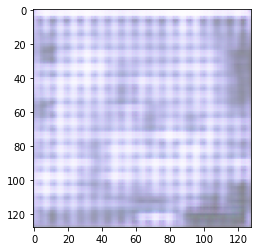

In [276]:
import matplotlib.pyplot as plt
plt.imshow(gen_imgs[14])

In [200]:
xtrain = np.array(train_df) / 255
xtrain = xtrain.reshape(21,128,128,3)

In [201]:
gen_imgs.shape

(16, 128, 128, 3)

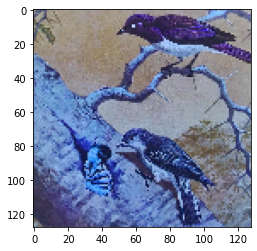

In [211]:
plt.imshow(xtrain[17])